PainTilt Experiment

2026-01-16 07:07:22.817731: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-16 07:07:22.819012: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-16 07:07:22.822599: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-16 07:07:22.833270: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768518442.851300   26966 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768518442.85

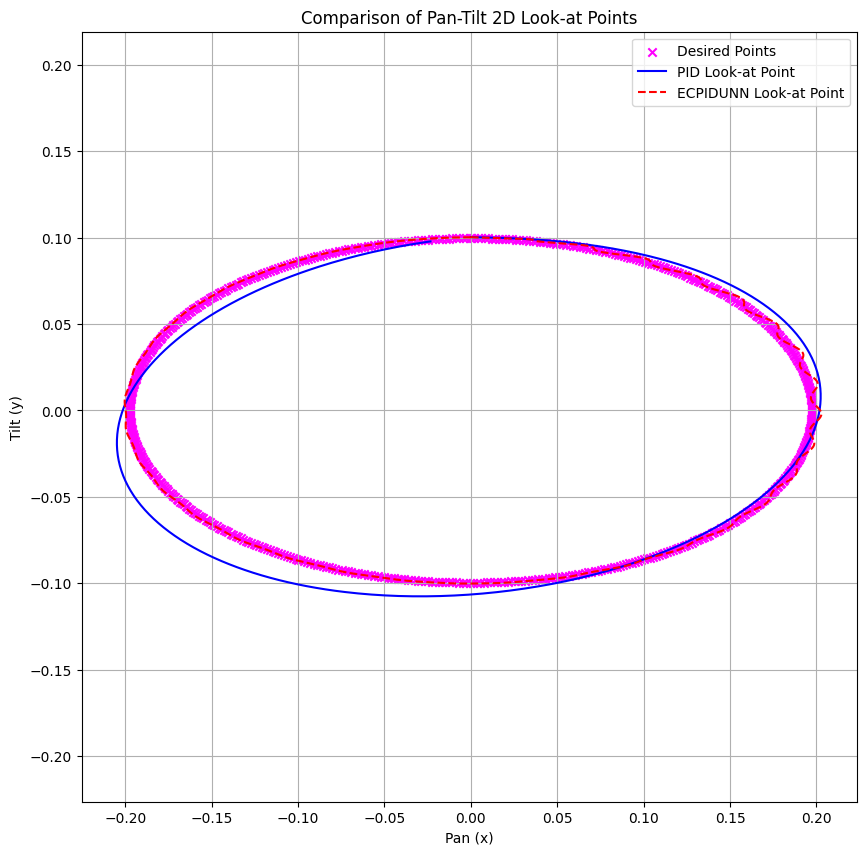

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ecpidunn import ECPIDUNN
from simple_pid import PID


class PanTilt:
    """Simulates a Pan-Tilt system with simple rotational dynamics."""
    def __init__(self, I_theta, I_phi, b_theta, b_phi, dt):
        self.I_theta, self.I_phi = I_theta, I_phi
        self.b_theta, self.b_phi = b_theta, b_phi
        self.dt = dt

        self.theta, self.omega_theta = 0.0, 0.0
        self.phi, self.omega_phi = 0.1, 0.0

    def update(self, control_theta, control_phi):
        self.omega_theta += (control_theta - self.b_theta * self.omega_theta) / self.I_theta * self.dt
        self.theta += self.omega_theta * self.dt

        self.omega_phi += (control_phi - self.b_phi * self.omega_phi) / self.I_phi * self.dt
        self.phi += self.omega_phi * self.dt

        return self.theta, self.phi


def desired_position(t):
    """Compute desired pan and tilt angles for a target trajectory."""
    x, y, z = 2 * np.sin(t), 1 * np.cos(t), 10
    return np.arctan2(x, z), np.arctan2(y, z)


def run_simulation(dt, total_time, pantilt_system, pan_controller, tilt_controller, use_ecpidnn=False):
    """
    Run simulation for Pan-Tilt system using either PID or ECPIDNN controllers.

    Args:
        dt: timestep
        total_time: total simulation time
        pantilt_system: PanTilt instance
        pan_controller, tilt_controller: controllers (PID or ECPIDNN)
        use_ecpidnn: flag to handle ECPIDNN predict call

    Returns:
        x_look_at_arr, y_look_at_arr, desired_positions
    """
    t = np.linspace(0, total_time, int(total_time / dt))
    x_look_at, y_look_at = [], []

    for ti in t:
        theta_des, phi_des = desired_position(ti)

        # Compute control signals
        if use_ecpidnn:
            control_theta = pan_controller.predict(np.array([theta_des - pantilt_system.theta], dtype=np.float32), verbose=0).squeeze()
            control_phi = tilt_controller.predict(np.array([phi_des - pantilt_system.phi], dtype=np.float32), verbose=0).squeeze()
        else:
            control_theta = pan_controller.update(theta_des, pantilt_system.theta)
            control_phi = tilt_controller.update(phi_des, pantilt_system.phi)

        # Update system state
        theta, phi = pantilt_system.update(control_theta, control_phi)
        x_look_at.append(np.tan(theta))
        y_look_at.append(np.tan(phi))

    desired_positions = np.array([desired_position(ti) for ti in t]).T
    return np.array(x_look_at), np.array(y_look_at), desired_positions


# Simulation parameters
dt = 0.01
total_time = 6.28 # Approximately one full circle

# Controllers
pid_pan = PID(Kp=2.9, Ki=1.5, Kd=3.5, dt=dt)
pid_tilt = PID(Kp=2.9, Ki=1.5, Kd=3.5, dt=dt)

ecpidnn_pan = ECPIDUNN(kp=2.9, ki=1.5, kd=3.5, dt=dt, pt=[0.1, 0.3, 0.4], tau=1.0).build_controller()
ecpidnn_tilt = ECPIDUNN(kp=2.9, ki=1.5, kd=3.5, dt=dt, pt=[0.1, 0.3, 0.4], tau=1.0).build_controller()

# Pan-Tilt systems
pantilt_pid = PanTilt(I_theta=0.3, I_phi=0.7, b_theta=0.3, b_phi=0.7, dt=dt)
pantilt_ecpidnn = PanTilt(I_theta=0.3, I_phi=0.7, b_theta=0.3, b_phi=0.7, dt=dt)

# Run simulations
x_pid, y_pid, desired_pid = run_simulation(dt, total_time, pantilt_pid, pid_pan, pid_tilt)
x_ecpidnn, y_ecpidnn, desired_ecpidnn = run_simulation(dt, total_time, pantilt_ecpidnn, ecpidnn_pan, ecpidnn_tilt, use_ecpidnn=True)

# Plot results
plt.figure(figsize=(10, 10))

# Desired trajectory
plt.scatter(*desired_ecpidnn, label='Desired Points', color='magenta', marker='x')

# PID and ECPIDNN look-at points
plt.plot(x_pid, y_pid, label='PID Look-at Point', color='blue')
plt.plot(x_ecpidnn, y_ecpidnn, label='ECPIDUNN Look-at Point', color='red', linestyle='--')

plt.xlabel('Pan (x)')
plt.ylabel('Tilt (y)')
plt.title('Comparison of Pan-Tilt 2D Look-at Points')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()


PanTilt Disturbance Analsyis

2026-01-17 01:43:41.686336: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-17 01:43:41.687187: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-17 01:43:41.689931: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-17 01:43:41.697393: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768585421.710252    4883 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768585421.71

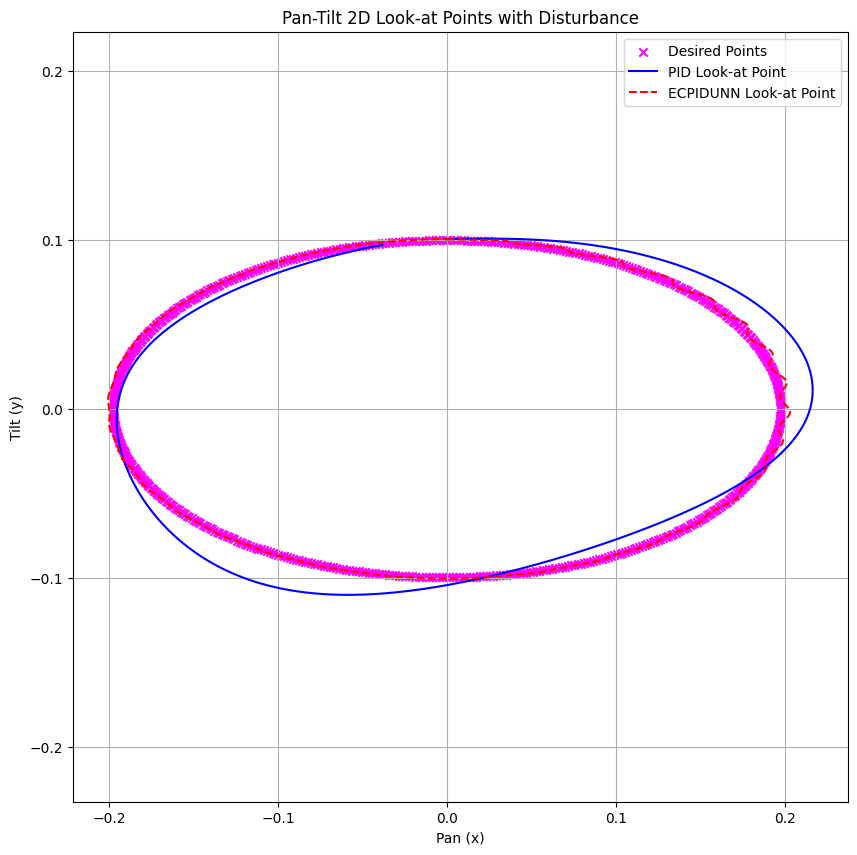

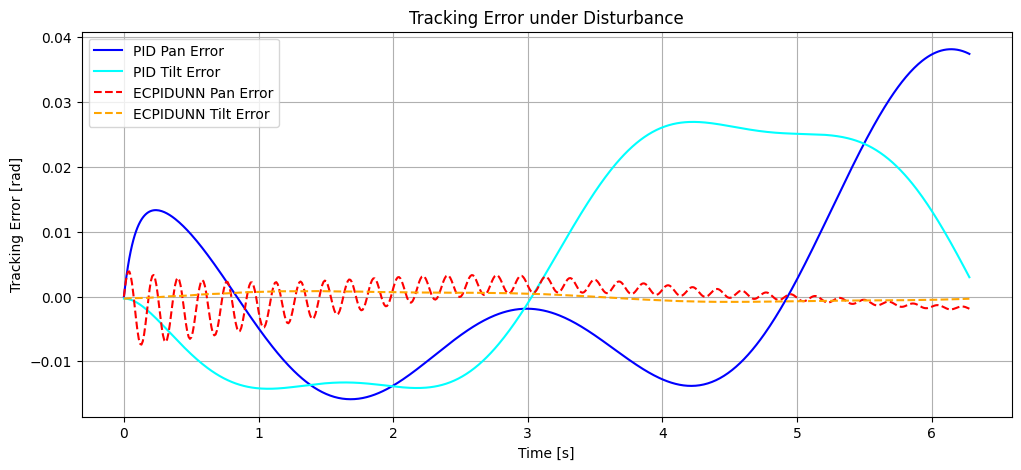

RMS Tracking Error (PID): 0.0233 rad
RMS Tracking Error (ECPIDUNN): 0.0022 rad


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ecpidunn import ECPIDUNN
from simple_pid import PID


class PanTilt:
    """Simulates a Pan-Tilt system with simple rotational dynamics and external disturbances."""
    def __init__(self, I_theta, I_phi, b_theta, b_phi, dt):
        self.I_theta, self.I_phi = I_theta, I_phi
        self.b_theta, self.b_phi = b_theta, b_phi
        self.dt = dt

        self.theta, self.omega_theta = 0.0, 0.0
        self.phi, self.omega_phi = 0.1, 0.0

    def update(self, control_theta, control_phi, disturbance_theta=0.0, disturbance_phi=0.0):
        self.omega_theta += (control_theta - self.b_theta * self.omega_theta + disturbance_theta) / self.I_theta * self.dt
        self.theta += self.omega_theta * self.dt

        self.omega_phi += (control_phi - self.b_phi * self.omega_phi + disturbance_phi) / self.I_phi * self.dt
        self.phi += self.omega_phi * self.dt

        return self.theta, self.phi


def desired_position(t):
    """Compute desired pan and tilt angles for a target trajectory."""
    x, y, z = 2 * np.sin(t), 1 * np.cos(t), 10
    return np.arctan2(x, z), np.arctan2(y, z)


def disturbance(t):
    """External disturbance signal (torque) applied to pan and tilt."""
    d_theta = 0.1 * np.sin(2 * t)   # Pan disturbance
    d_phi = 0.05 * np.cos(3 * t)    # Tilt disturbance
    return d_theta, d_phi


def run_simulation(dt, total_time, pantilt_system, pan_controller, tilt_controller, use_ecpidnn=False):
    """Run simulation with optional disturbances and either PID or ECPIDNN controllers."""
    t = np.linspace(0, total_time, int(total_time / dt))
    x_look_at, y_look_at = [], []
    error_theta_arr, error_phi_arr = [], []

    for ti in t:
        theta_des, phi_des = desired_position(ti)

        # Controller output
        if use_ecpidnn:
            control_theta = pan_controller.predict(np.array([theta_des - pantilt_system.theta], dtype=np.float32), verbose=0).squeeze()
            control_phi = tilt_controller.predict(np.array([phi_des - pantilt_system.phi], dtype=np.float32), verbose=0).squeeze()
        else:
            control_theta = pan_controller.update(theta_des, pantilt_system.theta)
            control_phi = tilt_controller.update(phi_des, pantilt_system.phi)

        # Apply disturbances
        d_theta, d_phi = disturbance(ti)
        theta, phi = pantilt_system.update(control_theta, control_phi, d_theta, d_phi)

        # Store look-at points and errors
        x_look_at.append(np.tan(theta))
        y_look_at.append(np.tan(phi))
        error_theta_arr.append(theta_des - theta)
        error_phi_arr.append(phi_des - phi)

    desired_positions = np.array([desired_position(ti) for ti in t]).T
    return np.array(x_look_at), np.array(y_look_at), desired_positions, np.array(error_theta_arr), np.array(error_phi_arr), t


# ----------------- Simulation Parameters -----------------
dt = 0.01
total_time = 6.28  # ~1 full circle

# PID Controllers
pid_pan = PID(Kp=2.9, Ki=1.5, Kd=3.5, dt=dt)
pid_tilt = PID(Kp=2.9, Ki=1.5, Kd=3.5, dt=dt)

# ECPIDNN Controllers
ecpidnn_pan = ECPIDUNN(kp=2.9, ki=1.5, kd=3.5, dt=dt, pt=[0.1, 0.3, 0.4], tau=1.0).build_controller()
ecpidnn_tilt = ECPIDUNN(kp=2.9, ki=1.5, kd=3.5, dt=dt, pt=[0.1, 0.3, 0.4], tau=1.0).build_controller()

# Pan-Tilt Systems
pantilt_pid = PanTilt(I_theta=0.3, I_phi=0.7, b_theta=0.3, b_phi=0.7, dt=dt)
pantilt_ecpidnn = PanTilt(I_theta=0.3, I_phi=0.7, b_theta=0.3, b_phi=0.7, dt=dt)

# ----------------- Run Simulations -----------------
x_pid, y_pid, desired_pid, err_theta_pid, err_phi_pid, t = run_simulation(dt, total_time, pantilt_pid, pid_pan, pid_tilt)
x_ecpidnn, y_ecpidnn, desired_ecpidnn, err_theta_ec, err_phi_ec, _ = run_simulation(dt, total_time, pantilt_ecpidnn, ecpidnn_pan, ecpidnn_tilt, use_ecpidnn=True)

# ----------------- Plot Look-at Points -----------------
plt.figure(figsize=(10, 10))
plt.scatter(*desired_ecpidnn, label='Desired Points', color='magenta', marker='x')
plt.plot(x_pid, y_pid, label='PID Look-at Point', color='blue')
plt.plot(x_ecpidnn, y_ecpidnn, label='ECPIDUNN Look-at Point', color='red', linestyle='--')
plt.xlabel('Pan (x)')
plt.ylabel('Tilt (y)')
plt.title('Pan-Tilt 2D Look-at Points with Disturbance')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

# ----------------- Plot Tracking Errors -----------------
plt.figure(figsize=(12, 5))
plt.plot(t, err_theta_pid, label='PID Pan Error', color='blue')
plt.plot(t, err_phi_pid, label='PID Tilt Error', color='cyan')
plt.plot(t, err_theta_ec, label='ECPIDUNN Pan Error', color='red', linestyle='--')
plt.plot(t, err_phi_ec, label='ECPIDUNN Tilt Error', color='orange', linestyle='--')
plt.xlabel('Time [s]')
plt.ylabel('Tracking Error [rad]')
plt.title('Tracking Error under Disturbance')
plt.legend()
plt.grid(True)
plt.show()

# ----------------- Compute RMS Errors -----------------
rms_pid = np.sqrt(np.mean(err_theta_pid**2 + err_phi_pid**2))
rms_ec = np.sqrt(np.mean(err_theta_ec**2 + err_phi_ec**2))
print(f"RMS Tracking Error (PID): {rms_pid:.4f} rad")
print(f"RMS Tracking Error (ECPIDUNN): {rms_ec:.4f} rad")


Ackermann-Car Experiment

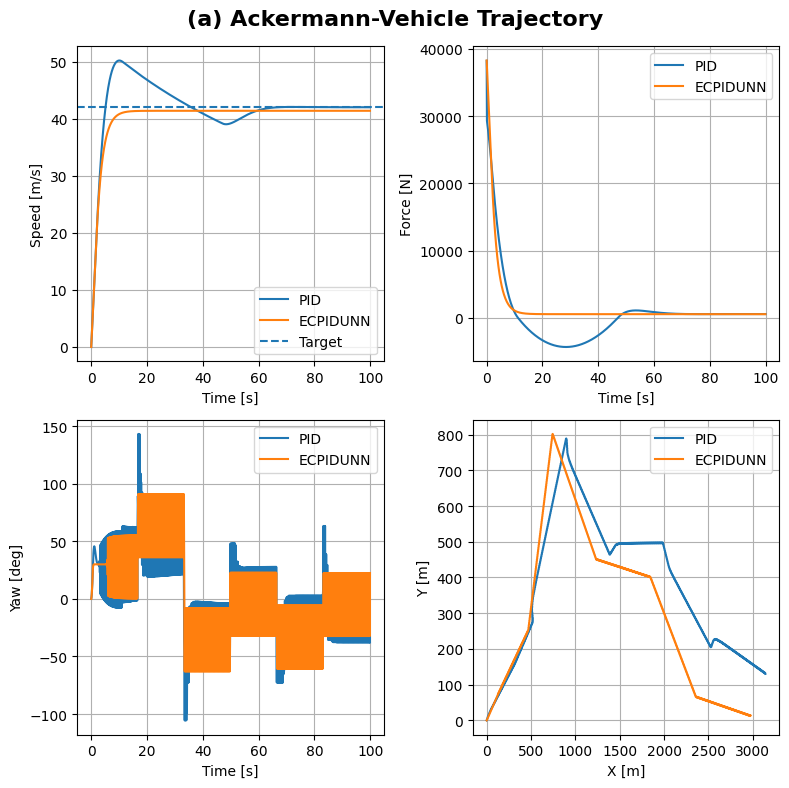

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ecpidunn import ECPIDUNN
from simple_pid import PID

# ---------------- Vehicle Model ----------------
class CarModel:
    """Simple car model with longitudinal and lateral dynamics."""
    def __init__(self, m, b, F_0, F_max, v_max, dt, L):
        self.m = m          # Vehicle mass [kg]
        self.b = b          # Aerodynamic drag coefficient
        self.F_0 = F_0      # Maximum applied force for PID controller [N]
        self.F_max = F_max  # Maximum allowed force for ECPIDUNN [N]
        self.v_max = v_max  # Maximum speed [m/s]
        self.dt = dt        # Simulation time step [s]
        self.L = L          # Wheelbase [m]

        # Vehicle state initialization
        self.x = 0.0        # X position [m]
        self.y = 0.0        # Y position [m]
        self.yaw = 0.0      # Yaw angle [rad]
        self.v = 0.0        # Speed [m/s]

    def update_speed(self, F):
        """Update vehicle speed based on applied longitudinal force."""
        F = np.clip(F, 0, self.F_0)  # Ensure force within limits
        self.v += (F - self.b * self.v**2) * (self.dt / self.m)

    def update_steering(self, delta):
        """Update vehicle position and yaw based on steering angle."""
        yaw_rate = (self.v / self.L) * np.tan(delta)
        self.yaw += yaw_rate * self.dt
        self.x += self.v * np.cos(self.yaw) * self.dt
        self.y += self.v * np.sin(self.yaw) * self.dt

    def get(self):
        """Return current state: x, y, yaw, speed."""
        return self.x, self.y, self.yaw, self.v

# ---------------- Simulation Parameters ----------------
dt = 0.1                # Time step [s]
run_time = 100           # Total simulation time [s]
n_steps = int(run_time / dt)  # Total simulation steps

# Vehicle parameters
mass = 2140              # kg
b = 0.33                 # Drag coefficient
F_max0 = 22000           # Max force for PID [N]
F_maxM = 1710            # Max force for ECPIDUNN [N]
v_max = 72               # Maximum speed [m/s]
L = 2.5                  # Wheelbase [m]
max_steer = np.deg2rad(30)  # Max steering angle [rad]

# Reference yaw targets (rad)
target_yaws = np.deg2rad([30, 50, -30, 0, -25, -10])
steps_per_yaw = n_steps // len(target_yaws)  # Steps per yaw segment

# Classical PID gains
Kpv, Kiv, Kdv = 700, 100, 20  # Speed PID
kpa, kia, kda = 1.0, 2.0, 0.1  # Yaw PID

# ---------------- Controllers ----------------
# Standard PID controllers
pid_v = PID(Kpv, Kiv, Kdv, dt)
pid_yaw = PID(kpa, kia, kda, dt)

# ECPIDUNN controllers
ecpid_v = ECPIDUNN(kp=Kpv, ki=Kiv, kd=Kdv, dt=dt, pt=[0.1, 0.3, 0.4], tau=1.0)
ecpid_y = ECPIDUNN(kp=kpa, ki=kia, kd=kda, dt=dt, pt=[0.1, 0.3, 0.4], tau=1.0)

# Build ECPIDUNN models
model_v = ecpid_v.build_controller()
model_y = ecpid_y.build_controller()

# ---------------- Vehicle Instances ----------------
car_pid = CarModel(mass, b, F_max0, F_maxM, v_max, dt, L)  # PID-controlled car
car_ecp = CarModel(mass, b, F_max0, F_maxM, v_max, dt, L)  # ECPIDUNN-controlled car

# ---------------- Data Logging ----------------
t = np.arange(n_steps) * dt

# Speed logs
v_pid = np.zeros(n_steps)
v_ecp = np.zeros(n_steps)

# Force commands
cmd_pid = np.zeros(n_steps)
cmd_ecp = np.zeros(n_steps)

# Yaw logs
yaw_pid = np.zeros(n_steps)
yaw_ecp = np.zeros(n_steps)

# Position logs
x_pid = np.zeros(n_steps)
y_pid = np.zeros(n_steps)
x_ecp = np.zeros(n_steps)
y_ecp = np.zeros(n_steps)

stp = 42  # Target speed [m/s]

# ---------------- Simulation Loop ----------------
for k in range(n_steps):
    # Determine current yaw reference
    yaw_idx = min(k // steps_per_yaw, len(target_yaws) - 1)
    yaw_ref = target_yaws[yaw_idx]

    # ----- PID Controller ----- #
    x, y, yaw, v = car_pid.get()
    F = pid_v.update(stp, v)  # Speed control
    delta = pid_yaw.update(yaw_ref, yaw)  # Steering control
    delta = np.clip(delta, -max_steer, max_steer)  # Limit steering angle

    car_pid.update_speed(F)
    car_pid.update_steering(delta)

    # Log PID results
    v_pid[k] = v
    cmd_pid[k] = F
    yaw_pid[k] = np.rad2deg(yaw)
    x_pid[k], y_pid[k] = x, y

    # ----- ECPIDUNN Controller ----- #
    x, y, yaw, v = car_ecp.get()

    # Predict control using ECPIDUNN
    F = model_v.predict(np.array([[stp - v]], dtype=np.float32), verbose=0).squeeze()
    delta = model_y.predict(np.array([[yaw_ref - yaw]], dtype=np.float32), verbose=0).squeeze()
    delta = np.clip(delta, -max_steer, max_steer)

    car_ecp.update_speed(F)
    car_ecp.update_steering(delta)

    # Log ECPIDUNN results
    v_ecp[k] = v
    cmd_ecp[k] = F
    yaw_ecp[k] = np.rad2deg(yaw)
    x_ecp[k], y_ecp[k] = x, y

# ---------------- Visualization ----------------
plt.figure(figsize=(8, 8))
plt.suptitle("(a) Ackermann-Vehicle Trajectory", fontsize=16,fontweight='bold')

# Speed plot
plt.subplot(2, 2, 1)
plt.plot(t, v_pid, label="PID")
plt.plot(t, v_ecp, label="ECPIDUNN")
plt.axhline(stp, linestyle="--", label="Target")
plt.xlabel("Time [s]")
plt.ylabel("Speed [m/s]")
plt.legend()
plt.grid()

# Force command plot
plt.subplot(2, 2, 2)
plt.plot(t, cmd_pid, label="PID")
plt.plot(t, cmd_ecp, label="ECPIDUNN")
plt.xlabel("Time [s]")
plt.ylabel("Force [N]")
plt.legend()
plt.grid()

# Yaw plot
plt.subplot(2, 2, 3)
plt.plot(t, yaw_pid, label="PID")
plt.plot(t, yaw_ecp, label="ECPIDUNN")
plt.xlabel("Time [s]")
plt.ylabel("Yaw [deg]")
plt.legend()
plt.grid()

# Trajectory plot
plt.subplot(2, 2, 4)
plt.plot(x_pid, y_pid, label="PID")
plt.plot(x_ecp, y_ecp, label="ECPIDUNN")
plt.xlabel("X [m]")
plt.ylabel("Y [m]")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


Ackermann-Car Disturbance Analaysis

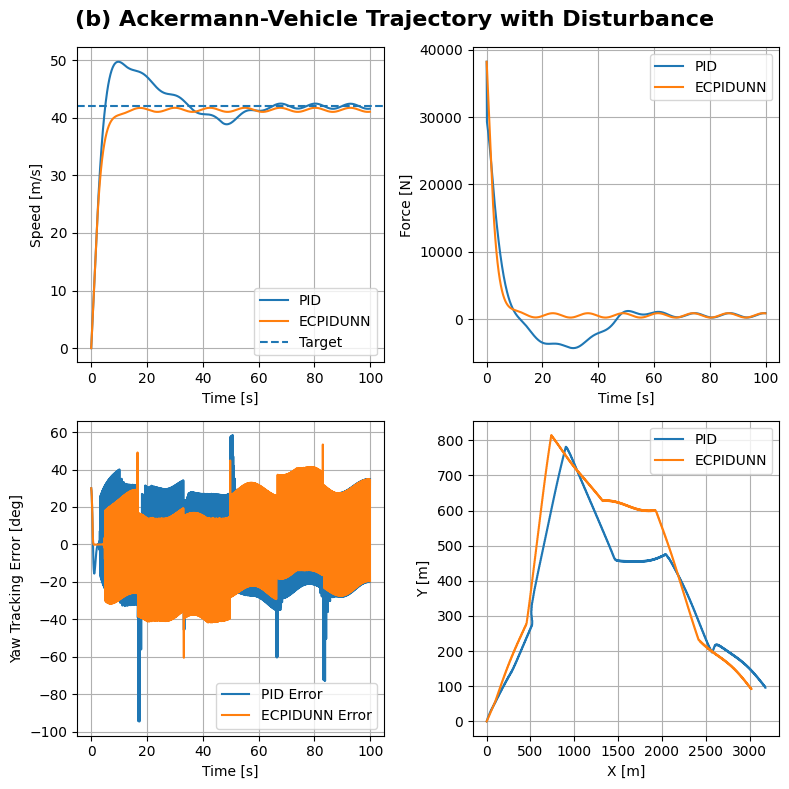

RMS Speed Error (PID): 5.76 m/s
RMS Speed Error (ECPIDUNN): 5.23 m/s
RMS Yaw Error (PID): 29.26 deg
RMS Yaw Error (ECPIDUNN): 28.14 deg


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from ecpidunn import ECPIDUNN
from simple_pid import PID

# ---------------- Vehicle Model ----------------
class CarModel:
    """Simple car model with longitudinal and lateral dynamics and external disturbances."""
    def __init__(self, m, b, F_0, F_max, v_max, dt, L):
        self.m = m
        self.b = b
        self.F_0 = F_0
        self.F_max = F_max
        self.v_max = v_max
        self.dt = dt
        self.L = L

        self.x = 0.0
        self.y = 0.0
        self.yaw = 0.0
        self.v = 0.0

    def update_speed(self, F, tau_v=0.0):
        F = np.clip(F, 0, self.F_0)
        self.v += ((F - self.b * self.v**2 + tau_v) / self.m) * self.dt

    def update_steering(self, delta, tau_psi=0.0):
        yaw_rate = (self.v / self.L) * np.tan(delta) + tau_psi
        self.yaw += yaw_rate * self.dt
        self.x += self.v * np.cos(self.yaw) * self.dt
        self.y += self.v * np.sin(self.yaw) * self.dt

    def get(self):
        return self.x, self.y, self.yaw, self.v

# ---------------- Simulation Parameters ----------------
dt = 0.1
run_time = 100
n_steps = int(run_time / dt)

# Vehicle parameters
mass = 2140
b = 0.33
F_max0 = 22000
F_maxM = 1710
v_max = 72
L = 2.5
max_steer = np.deg2rad(30)

# Reference yaws
target_yaws = np.deg2rad([30, 50, -30, 0, -25, -10])
steps_per_yaw = n_steps // len(target_yaws)

# PID gains
Kpv, Kiv, Kdv = 700, 100, 20
kpa, kia, kda = 1.0, 2.0, 0.1

# ---------------- Controllers ----------------
pid_v = PID(Kpv, Kiv, Kdv, dt)
pid_yaw = PID(kpa, kia, kda, dt)

ecpid_v = ECPIDUNN(kp=Kpv, ki=Kiv, kd=Kdv, dt=dt, pt=[0.1,0.3,0.4], tau=1.0)
ecpid_y = ECPIDUNN(kp=kpa, ki=kia, kd=kda, dt=dt, pt=[0.1,0.3,0.4], tau=1.0)

model_v = ecpid_v.build_controller()
model_y = ecpid_y.build_controller()

# ---------------- Vehicle Instances ----------------
car_pid = CarModel(mass, b, F_max0, F_maxM, v_max, dt, L)
car_ecp = CarModel(mass, b, F_max0, F_maxM, v_max, dt, L)

# ---------------- Data Logging ----------------
t = np.arange(n_steps) * dt

v_pid_log = np.zeros(n_steps)
v_ecp_log = np.zeros(n_steps)
yaw_pid_log = np.zeros(n_steps)
yaw_ecp_log = np.zeros(n_steps)
x_pid_log = np.zeros(n_steps)
y_pid_log = np.zeros(n_steps)
x_ecp_log = np.zeros(n_steps)
y_ecp_log = np.zeros(n_steps)
cmd_pid_log = np.zeros(n_steps)
cmd_ecp_log = np.zeros(n_steps)
error_yaw_pid = np.zeros(n_steps)
error_yaw_ecp = np.zeros(n_steps)

# Target speed
v_target = 42  # m/s

# ---------------- Disturbances ----------------
def disturbance(t):
    """Longitudinal and lateral disturbances."""
    tau_v = 500 * np.sin(0.5 * t)      # N
    tau_psi = 0.02 * np.cos(0.3 * t)   # rad
    return tau_v, tau_psi

# ---------------- Simulation Loop ----------------
for k in range(n_steps):
    yaw_idx = min(k // steps_per_yaw, len(target_yaws)-1)
    yaw_ref = target_yaws[yaw_idx]

    # ----- PID Controller ----- #
    x, y, yaw, v = car_pid.get()
    tau_v, tau_psi = disturbance(t[k])
    F = pid_v.update(v_target, v)
    delta = pid_yaw.update(yaw_ref, yaw)
    delta = np.clip(delta, -max_steer, max_steer)

    car_pid.update_speed(F, tau_v)
    car_pid.update_steering(delta, tau_psi)

    v_pid_log[k] = v
    yaw_pid_log[k] = np.rad2deg(yaw)
    x_pid_log[k], y_pid_log[k] = x, y
    cmd_pid_log[k] = F
    error_yaw_pid[k] = yaw_ref - yaw  # Store yaw error in rad

    # ----- ECPIDUNN Controller ----- #
    x, y, yaw, v = car_ecp.get()
    tau_v, tau_psi = disturbance(t[k])
    F = model_v.predict(np.array([[v_target - v]], dtype=np.float32), verbose=0).squeeze()
    delta = model_y.predict(np.array([[yaw_ref - yaw]], dtype=np.float32), verbose=0).squeeze()
    delta = np.clip(delta, -max_steer, max_steer)

    car_ecp.update_speed(F, tau_v)
    car_ecp.update_steering(delta, tau_psi)

    v_ecp_log[k] = v
    yaw_ecp_log[k] = np.rad2deg(yaw)
    x_ecp_log[k], y_ecp_log[k] = x, y
    cmd_ecp_log[k] = F
    error_yaw_ecp[k] = yaw_ref - yaw  # Store yaw error

# ---------------- Visualization ----------------
plt.figure(figsize=(8,8))
plt.suptitle("(b) Ackermann-Vehicle Trajectory with Disturbance", fontsize=16, fontweight='bold')

# Speed
plt.subplot(2,2,1)
plt.plot(t, v_pid_log, label='PID')
plt.plot(t, v_ecp_log, label='ECPIDUNN')
plt.axhline(v_target, linestyle='--', label='Target')
plt.xlabel('Time [s]')
plt.ylabel('Speed [m/s]')
plt.legend()
plt.grid()

# Force command
plt.subplot(2,2,2)
plt.plot(t, cmd_pid_log, label='PID')
plt.plot(t, cmd_ecp_log, label='ECPIDUNN')
plt.xlabel('Time [s]')
plt.ylabel('Force [N]')
plt.legend()
plt.grid()

# Yaw
plt.subplot(2,2,3)
plt.plot(t, np.rad2deg(error_yaw_pid), label='PID Error')
plt.plot(t, np.rad2deg(error_yaw_ecp), label='ECPIDUNN Error')
plt.xlabel('Time [s]')
plt.ylabel('Yaw Tracking Error [deg]')
plt.legend()
plt.grid()

# Trajectory
plt.subplot(2,2,4)
plt.plot(x_pid_log, y_pid_log, label='PID')
plt.plot(x_ecp_log, y_ecp_log, label='ECPIDUNN')
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# ---------------- RMS Error ----------------
rms_v_pid = np.sqrt(np.mean((v_target - v_pid_log)**2))
rms_v_ecp = np.sqrt(np.mean((v_target - v_ecp_log)**2))
rms_yaw_pid = np.sqrt(np.mean(error_yaw_pid**2))
rms_yaw_ecp = np.sqrt(np.mean(error_yaw_ecp**2))

print(f"RMS Speed Error (PID): {rms_v_pid:.2f} m/s")
print(f"RMS Speed Error (ECPIDUNN): {rms_v_ecp:.2f} m/s")
print(f"RMS Yaw Error (PID): {np.rad2deg(rms_yaw_pid):.2f} deg")
print(f"RMS Yaw Error (ECPIDUNN): {np.rad2deg(rms_yaw_ecp):.2f} deg")


Run-time Experiment

In [1]:
import time
import tracemalloc
import numpy as np
from simple_pid import PID
from ecpidunn import ECPIDUNN

# ---------------- Simulation Parameters ----------------
n_steps = 1  # Number of forward passes
error_signal = np.random.randn(n_steps).astype(np.float32)  # Random input error

# ---------------- PID Controller ----------------
Kp, Ki, Kd = 1.0, 0.1, 0.01
pid = PID(Kp, Ki, Kd, dt=0.01)

# ---------------- ECPIDUNN Controller ----------------
ecpid = ECPIDUNN(kp=Kp, ki=Ki, kd=Kd, dt=0.01, pt=[0.1, 0.3, 0.4], tau=1.0)
model = ecpid.build_controller()

# ---------------- Experiment Function ----------------
def run_forward_pass(controller_type="PID"):
    outputs = []

    tracemalloc.start()
    start_time = time.time()

    for e in error_signal:
        if controller_type == "PID":
            out = pid.update(e, 0)  # Target=0, error=e
        elif controller_type == "ECPIDUNN":
            out = model.predict(np.array([[e]], dtype=np.float32), verbose=0).squeeze()
        else:
            raise ValueError("Unknown controller type")
        outputs.append(out)

    runtime = time.time() - start_time
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    return runtime, peak / 1024  # peak memory in KB

# ---------------- Run Experiments ----------------
pid_time, pid_mem = run_forward_pass("PID")
ecp_time, ecp_mem = run_forward_pass("ECPIDUNN")

print(f"PID: Runtime = {pid_time:.4f} s, Peak memory = {pid_mem:.2f} KB")
print(f"ECPIDUNN: Runtime = {ecp_time:.4f} s, Peak memory = {ecp_mem:.2f} KB")


2026-01-16 07:22:40.400895: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-16 07:22:40.402129: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-16 07:22:40.405982: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-16 07:22:40.415446: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768519360.434068   23491 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768519360.43

PID: Runtime = 0.0001 s, Peak memory = 1.12 KB
ECPIDUNN: Runtime = 0.8611 s, Peak memory = 1853.56 KB
